## Part -1: env setup

In a terminal:
    
```
source activate tensorflow_p36
pip install -U keras-preprocessing yellowbrick
```

Then reload this notebook kernel.

## Part 0: wrapping keras classifiers as scikit-learn objects

## Part 1: hacking classification

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout


# local metadata filepath
metadata_filepath = '../comet/data/training/X_meta.csv'
# remote metadata filepath
# metadata_filepath = 'X_meta.csv'

# local images filepath
images_cropped = '../comet/data/images_cropped/'


X_meta = (pd.read_csv(metadata_filepath)
          .groupby('LabelName')
          .head(1000)
          .groupby('LabelName')
          .filter(lambda gdf: len(gdf) >= 1000)
          .reset_index(drop=True))

Using TensorFlow backend.


In [2]:
# define training generators
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

batch_size = 64

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1/255
)
train_generator = train_datagen.flow_from_dataframe(
    X_meta,
    directory=images_cropped,
    x_col='CroppedImageURL',
    y_col='LabelName',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_dataframe(
    X_meta,
    directory=images_cropped,
    x_col='CroppedImageURL',
    y_col='LabelName',    
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# define the model
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import SGD

def bottleneck():
    prior = keras.applications.VGG16(
        include_top=False, 
        weights='imagenet',
        input_shape=(48, 48, 3)
    )
    model = Sequential()
    model.add(prior)
    model.add(Flatten())
    model.add(Dense(256, activation='relu', name='Dense_Intermediate'))
    model.add(Dropout(0.2, name='Dropout_Regularization'))
    model.add(Dense(8, activation='sigmoid', name='Output'))
    model.layers[0].trainable = False
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# define the KerasClassifier wrapper...wrapper
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import BaseEstimator
class KerasBatchClassifier(KerasClassifier, BaseEstimator):
    def __init__(self, model, **kwargs):
        super().__init__(model)
        self.fit_kwargs = kwargs
        self._estimator_type = 'classifier'

    def fit(self, *args, **kwargs):
        # taken from keras.wrappers.scikit_learn.KerasClassifier.fit
        self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
        
        self.classes_ = np.array(range(len(self.fit_kwargs['train_generator'].class_indices)))
        self.__history = self.model.fit_generator(
            self.fit_kwargs.pop('train_generator'), 
            **self.fit_kwargs
        )

clf = KerasBatchClassifier(
    bottleneck,
    train_generator=train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    validation_data=validation_generator,
    validation_steps=len(train_generator.filenames) // batch_size,
    callbacks=[EarlyStopping(patience=1, restore_best_weights=True)]
)

Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


In [3]:
clf.fit()

Epoch 1/10
  1/100 [..............................] - ETA: 8:12 - loss: 2.0614 - acc: 0.1562

KeyboardInterrupt: 

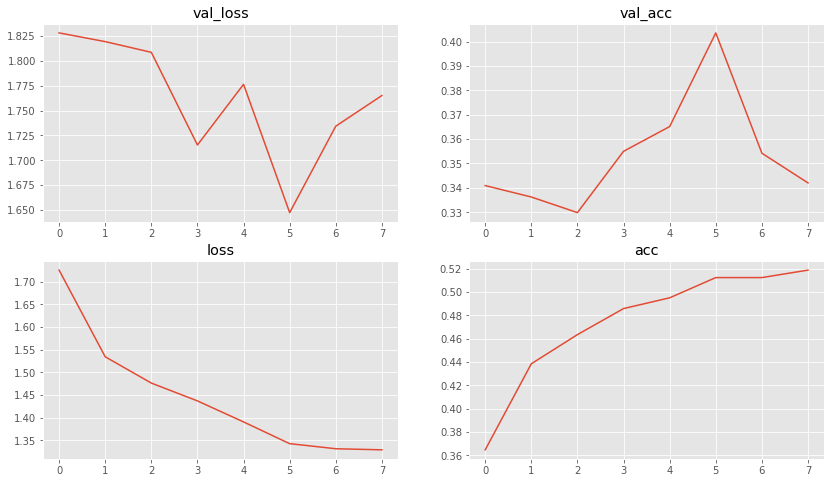

In [119]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, axarr = plt.subplots(2, 2, figsize=(14, 8))
for i, metric in enumerate(clf.model.history.history):
    res = clf.model.history.history[metric]
    j, k = i // 2, i % 2
    axarr[j][k].plot(range(len(res)), res)
    axarr[j][k].set_title(metric)

In [6]:
visualization_generator = train_datagen.flow_from_dataframe(
    X_meta,
    directory=images_cropped,
    x_col='CroppedImageURL',
    y_col='LabelName',    
    target_size=(48, 48),
    batch_size=1024,
    class_mode='categorical',
    subset='validation'
)

Found 1600 images belonging to 8 classes.


1024/1024 [==============================] - 1s 854us/step


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


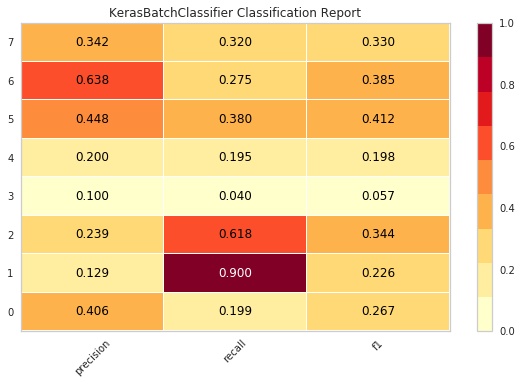

In [236]:
import numpy as np
from yellowbrick.classifier import ClassificationReport

X, y = visualization_generator.next()
y = np.argmax(y, axis=1)

visualizer = ClassificationReport(clf)
visualizer.score(X, y)
visualizer.poof()

576/576 [==============================] - 0s 841us/step


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


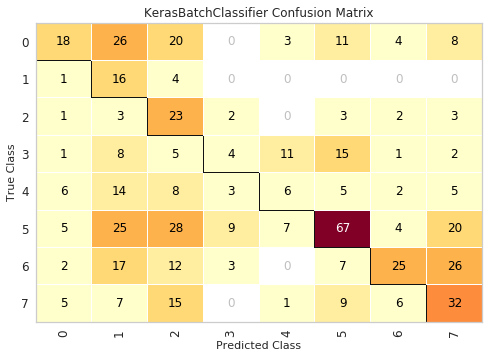

In [237]:
from yellowbrick.classifier import ConfusionMatrix

X, y = visualization_generator.next()
y = np.argmax(y, axis=1)

visualizer = ConfusionMatrix(clf)
visualizer.score(X, y)
visualizer.poof()

Found 1600 images belonging to 8 classes.
kwargs["colors"] None
classes [0 1 2 3 4 5 6 7]
n_colors 8
colors [(0.00784313725490196, 0.4470588235294118, 0.6352941176470588), (0.6235294117647059, 0.7647058823529411, 0.4666666666666667), (0.792156862745098, 0.043137254901960784, 0.011764705882352941), (0.6470588235294118, 0.00784313725490196, 0.34509803921568627), (0.8431372549019608, 0.7803921568627451, 0.011764705882352941), (0.5333333333333333, 0.792156862745098, 0.8549019607843137), (0.00784313725490196, 0.4470588235294118, 0.6352941176470588), (0.6235294117647059, 0.7647058823529411, 0.4666666666666667)]
classes_ [0 1 2 3 4 5 6 7]
1024/1024 [==============================] - 59s 58ms/step


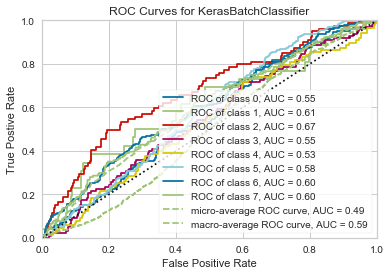

In [7]:
%matplotlib inline 

visualization_generator = train_datagen.flow_from_dataframe(
    X_meta,
    directory=images_cropped,
    x_col='CroppedImageURL',
    y_col='LabelName',    
    target_size=(48, 48),
    batch_size=1024,
    class_mode='categorical',
    subset='validation'
)

from yellowbrick.classifier import ROCAUC

X, y = visualization_generator.next()
y = np.argmax(y, axis=1)

# If you do not initialize with classes, yellowbrick will use a default matplotlib 
# color cycle which has only six entries in it. If you have more than six classes,
# this will break.
visualizer = ROCAUC(clf, classes=np.unique(y))
visualizer.score(X, y)
visualizer.poof()

# TODO: debug the error

`PrecisionRecallCurve` must call its `fit` method in order to be used, because it requires running or re-running the model in a one-versus-rest scheme to calculate metrics. That run is parallelized using `sklearn` internal parallelization, which seems to rely on deeper configuration details of how `sklearn` model objects are supported to be shaped that `KerasClassifier` will not submit to naively. As a result this method fails during an internal `clone` procedure run during.

This is very non-trivial to fix. Here is the full traceback:

```
Found 1600 images belonging to 8 classes.
> /Users/alex/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/yellowbrick/classifier/prcurve.py(172)fit()
-> if ttype.startswith(MULTICLASS):
(Pdb) c
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-6-5c7536859d2d> in <module>
     31 
     32 visualizer = PrecisionRecallCurve(clf2)
---> 33 visualizer.fit(X, y)
     34 visualizer.score(X, y)
     35 visualizer.poof()

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/yellowbrick/classifier/prcurve.py in fit(self, X, y)
    170         ttype = type_of_target(y)
    171         if ttype.startswith(MULTICLASS):
--> 172             self.target_type_ = MULTICLASS
    173             self.estimator = OneVsRestClassifier(self.estimator)
    174 

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/yellowbrick/classifier/base.py in fit(self, X, y, **kwargs)
    102         """
    103         # Fit the inner estimator
--> 104         self.estimator.fit(X, y)
    105 
    106         # Extract the classes from the estimator

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/sklearn/multiclass.py in fit(self, X, y)
    213                 "not %s" % self.label_binarizer_.classes_[i],
    214                 self.label_binarizer_.classes_[i]])
--> 215             for i, column in enumerate(columns))
    216 
    217         return self

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self, iterable)
    915             # remaining jobs.
    916             self._iterating = False
--> 917             if self.dispatch_one_batch(iterator):
    918                 self._iterating = self._original_iterator is not None
    919 

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in dispatch_one_batch(self, iterator)
    757                 return False
    758             else:
--> 759                 self._dispatch(tasks)
    760                 return True
    761 

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in _dispatch(self, batch)
    714         with self._lock:
    715             job_idx = len(self._jobs)
--> 716             job = self._backend.apply_async(batch, callback=cb)
    717             # A job can complete so quickly than its callback is
    718             # called before we get here, causing self._jobs to

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py in apply_async(self, func, callback)
    180     def apply_async(self, func, callback=None):
    181         """Schedule a func to be run"""
--> 182         result = ImmediateResult(func)
    183         if callback:
    184             callback(result)

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py in __init__(self, batch)
    547         # Don't delay the application, to avoid keeping the input
    548         # arguments in memory
--> 549         self.results = batch()
    550 
    551     def get(self):

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self)
    223         with parallel_backend(self._backend, n_jobs=self._n_jobs):
    224             return [func(*args, **kwargs)
--> 225                     for func, args, kwargs in self.items]
    226 
    227     def __len__(self):

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0)
    223         with parallel_backend(self._backend, n_jobs=self._n_jobs):
    224             return [func(*args, **kwargs)
--> 225                     for func, args, kwargs in self.items]
    226 
    227     def __len__(self):

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/sklearn/multiclass.py in _fit_binary(estimator, X, y, classes)
     77         estimator = _ConstantPredictor().fit(X, unique_y)
     78     else:
---> 79         estimator = clone(estimator)
     80         estimator.fit(X, y)
     81     return estimator

~/miniconda3/envs/yellowbricks-investigation/lib/python3.6/site-packages/sklearn/base.py in clone(estimator, safe)
     63     for name, param in six.iteritems(new_object_params):
     64         new_object_params[name] = clone(param, safe=False)
---> 65     new_object = klass(**new_object_params)
     66     params_set = new_object.get_params(deep=False)
     67 

TypeError: __init__() missing 1 required positional argument: 'model'
```

In [7]:
# see comment above
# clf2 = KerasBatchClassifier(
#     bottleneck,
#     train_generator=train_generator,
#     epochs=1,
#     steps_per_epoch=len(train_generator.filenames) // batch_size,
#     validation_data=validation_generator,
#     validation_steps=len(train_generator.filenames) // batch_size,
#     callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
# )

# visualization_generator = train_datagen.flow_from_dataframe(
#     X_meta,
#     directory=images_cropped,
#     x_col='CroppedImageURL',
#     y_col='LabelName',    
#     target_size=(48, 48),
#     batch_size=1024,
#     class_mode='categorical',
#     subset='validation'
# )

# from yellowbrick.classifier import PrecisionRecallCurve

# X, y = visualization_generator.next()
# y = np.argmax(y, axis=1)

# visualizer = PrecisionRecallCurve(clf2)
# visualizer.fit(X, y)
# visualizer.score(X, y)
# visualizer.poof()

576/576 [==============================] - 1s 868us/step


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


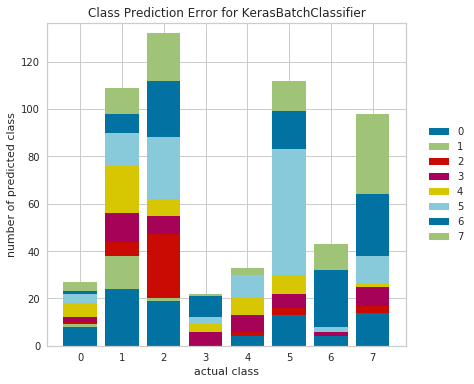

In [251]:
from yellowbrick.classifier import ClassPredictionError

X, y = visualization_generator.next()
y = np.argmax(y, axis=1)

visualizer = ClassPredictionError(clf)
visualizer.score(X, y)
visualizer.poof()

In [12]:
clf3 = KerasBatchClassifier(
    bottleneck,
    train_generator=train_generator,
    epochs=10,
    steps_per_epoch=16,
    validation_data=validation_generator,
    validation_steps=16,
    callbacks=[EarlyStopping(patience=1, restore_best_weights=True)]
)

clf3.fit()

Found 400 images belonging to 2 classes.
Epoch 1/10
  1/100 [..............................] - ETA: 6:22 - loss: 2.1854 - acc: 0.1562

KeyboardInterrupt: 

TODO: write a `DiscriminationThreshold` case (binary).

Found 400 images belonging to 2 classes.


ValueError: Error when checking target: expected Output to have shape (8,) but got array with shape (2,)

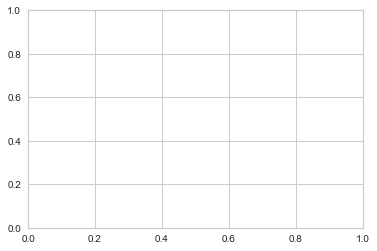

In [17]:
from yellowbrick.classifier import DiscriminationThreshold

binary_visualization_generator = train_datagen.flow_from_dataframe(
    X_meta.query('LabelName == "Orange" or LabelName == "Strawberry"'),
    directory=images_cropped,
    x_col='CroppedImageURL',
    y_col='LabelName',    
    target_size=(48, 48),
    batch_size=1024,
    class_mode='categorical',
    subset='validation'
)
X, y = binary_visualization_generator.next()
y = np.argmax(y, axis=1)


visualizer = DiscriminationThreshold(clf3)
visualizer.score(X, y)
visualizer.poof()

## Part 2: hacking model selection

Set this aside. There are problems parallelizing the model runs that need deeper PR involvement to fix.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Found array with dim 4. Estimator expected <= 2.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


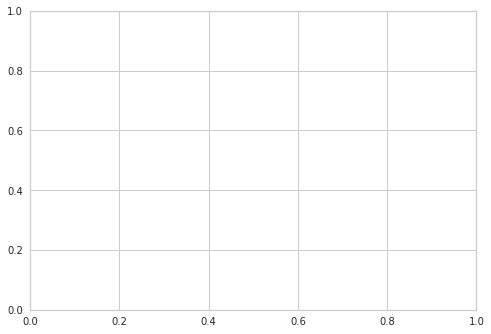

In [255]:
# import numpy as np

# from sklearn.tree import DecisionTreeClassifier
# from yellowbrick.model_selection import ValidationCurve

# viz = ValidationCurve(
#     DecisionTreeClassifier(), param_name="max_depth",
#     param_range=np.arange(1, 11), cv=10, scoring="r2"
# )

# # Fit and poof the visualizer
# viz.fit(X, y)
# viz.poof()

## Part 3: hacking regression

TODO: separate notebook.